<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-3-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# NN Heston Model - Parameters Generation

In [1]:
!pip install -q smt

     |████████████████████████████████| 252 kB 11.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 297 kB/s 
     |████████████████████████████████| 3.1 MB 70.6 MB/s 
     |████████████████████████████████| 90 kB 6.1 MB/s 
     |████████████████████████████████| 121 kB 61.4 MB/s 
     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 100 kB 6.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from smt.sampling_methods import LHS
from sklearn.model_selection import train_test_split

## Introduction

Pricing in mathematical finance is building a complex function from a model following some constraint.
Since models are just a rough description of markets, we accept the fact that each day we do 'calibrate'
models in order to match as much as possible what we see on the market. The complexity of the calibration procedure depends on the complexity of the underlying model deemed capable to describe the market situation. Most of the effort in applying neural networks to pricing has gone into the direction of devising 
clever shortcuts to the calibration mechanism.

We want to bypass this phase exploting the fact that pricing with a calibrated model amounts to 
the composition of two functions: one from market data to model parameters, the second from model 
paramters to market data. This approach is in itself not new. Some authors have attempted the path of walking directly from
market data to prices, leaving the model aside. In doing that they needed to train a network directly on market values. This approach required verylong time series and was able to train the netowrk only on quoted vanilla option.

In our approch, the assumption that the model, properly calibrated, is capable to describe the market with 
enough accuracy, is an essential element.

Given that we have outlined these concepts we can simply states the main goals of out work:

- dispose of the burden of having to calibrate models
- remove the need for ridiculously long time series of market data and option prices
- get rid of all of the computational bottlenecks when going from market to prices.

At this point, some of these goals need further explanation. That will come in due time. Let's start looking at a very simple example. For instance, if we resort to the Black-Scholes model:

\begin{align}
    dS_t &= S_t \sigma dW_t \nonumber
\end{align}

for a claim written on a single asset, all we have to do is to select the appropriate value for the volatility. And this is all is needed in terms of model calibration. If we are dealing with claims written on several assets, besides the volatility for each individual asset we have to decide on the correlations.

\begin{align}
    dS^i_t &= S^i_t \sigma^i dW^i_t \nonumber
\\ \mathbb{E}[ dW^i_t dW^j_t\,] &= \rho_{ij} dt \nonumber
\end{align}

Things get a lot more involved if we use more advanced models like stochastic volatility models. 
For example, if we adopt the Heston model: 

\begin{align}
    dS_t &= S_t \sqrt{\nu_t} dW_t \nonumber
    \\ d\nu_t &= k ( \theta - \nu_t) dt + \eta\sqrt{\nu_t} dY_t, \quad \nu_0 = \overline{\nu} \nonumber
\\ {\mathbb E}[ dW_t dY_t\,] &= \rho dt \nonumber
\end{align}

we have to calibrate the four parameters of the process of the stochastic volatility $(k, \theta, \nu_0, \eta)$ 
and the correlation term $(\rho)$ between the innovation processes.

Still more complex is the situation if we want to tackle some IR product. In that case, even using a very simple
model like the one factro Hull-White model:

\begin{align}
 dr(t) = k( \theta(t) - r(t) ) dt  + \sigma dW_t, \quad r(0) = r_o
\end{align}

besides parameters $(k, r_o, \sigma)$ we are asked to calibrate a whole curve $\theta(t)$
needed to match today's observed discount curve.

## Standard approach to ML

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\def\Em{\mathbb E}$

Let's call $\Pi( \vect{\alpha}, G(\vect{g}) )$ the function pricing a position $G$ with a model described
collectively by the parameters $\vect{\alpha}$, and the position described by the parameters $\vect{g}$. To be clear, in case of an option $\vect{g}$ could be the the pair maturity and strike. 

A standard ML exercise would call for 

- generating, according to some random rule, a set of parameters $\vect{\alpha}_n,\; \vect{g}_n\; 1 \le n \le N$,</li>
- for each $\vect{\alpha}_n\, \vect{g}_n$ compute the function pricing a derivative $G$ with a model described by the parameter set $\vect{\alpha}_n$. We define the total parameter set as  $\Pi_n := \Pi( \vect{\alpha}_n, G(\vect{g}_n))$
 
       
Iterating the procedure described above, we can build a large matrix 
    
 <table>   
     <tr>
         <th colspan="2">Features (Regressors)</th>
         <th>Label (Target)</th>
     </tr>
     <tr>
         <td> $\vect{\alpha}_1$</td> 
         <td> $\vect{g}_1 $    </td> 
         <td>    $\Pi_1$       </td>
     </tr>
     <tr>
         <td>$\vect{\alpha}_2$</td>
         <td>$\vect{g}_2 $    </td>
         <td>$\Pi_2$          </td>
     </tr>
     <tr> <td></td><td>...</td><td></td> </tr>
     <tr> 
         <td>$\vect{\alpha}_N$</td>
         <td>$\vect{g}_N $</td>
         <td>$\Pi_N$</td>
     </tr>
</table>
    
and use it to train a neural network that, if all goes well, will learn the map

\begin{equation}
    \phi_{NN}: \vect{\alpha}, \vect{g} \rightarrow \Pi(\vect{\alpha}, G).
\end{equation}     

## Generating Dataset

### Python support functions

#### Plotting Functions

In [6]:
def histo_dict(df, TAG = '0000'):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s (len=%d)" %(k,len(x)))
        n += 1
    
    #plt.savefig("pdf_%s.png" %TAG, format="png")
    plt.savefig("param_pdf.png", format="png")
    plt.show()


In [7]:
def histo_params( x, title = "None"):
    keys = list(x)
    LEN  = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        tag  = keys[n]
        lo   = np.min(x[tag])
        hi   = np.max(x[tag])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[tag], density=True, facecolor='g', bins=bins)
        ax[n].set_title(tag)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()


#### Pricing Functions

This is the pricing function for the Heston Model we use in this example. The `Heston` class and the `ft_opt` function are defined in the `Lib` module. For a complete description of the Heston model refer to the Computational Finance Lecture Notes of Pietro Rossi.

In [8]:
import math
import cmath
from math import *
import numpy as np

#      1 + g
#  ---------------------
#    1 + g exp( - gamma * T )
#
def arg_log( c_gmma, c_g, T):
    return (1.0 + c_g)/(1.0 + c_g*cmath.exp(-c_gmma*T))

#
#  C = 2 * log( (1 - g) / ( 1 - g e^{-gamma T } ) )/sigma^2
#  arg_log := (1 - g) / ( 1 - g e^{-gamma T } )
#
def C( c_gmma, c_g, sigma, T):
    c_psi = arg_log(c_gmma, c_g, T)
    return 2*cmath.log(c_psi)/pow(sigma,2)

#
# .5 ( v - v^2 )
#
def Lambda( c_v): 
    return .5*c_v - .5*c_v*c_v

#
# Gamma =  SQRT( kappa^2 + 2 L sigma^2 )
#
def Gamma( c_L, c_kappa, sigma):
    return cmath.sqrt(c_kappa*c_kappa + 2.*c_L*pow(sigma,2))
#
# g = ( gamma - kappa )/( gamma + kappa );
#
def G( c_kappa, c_gmma):
    return (c_gmma - c_kappa)/(c_gmma + c_kappa)

#
# Z_p = ( gamma - kappa )/sigma^2
#
def Z_p( c_gmma, c_kappa, sigma):
    return (c_gmma - c_kappa)/pow(sigma,2);
#
#
# A = -kappa * theta * ( zp * T - C)
#
def A_tT( c_gmma, c_g, c_zp, c_kappa, c_theta, sigma, T):
    c_c  = C( c_gmma, c_g, sigma, T)
    c_kt = c_kappa * c_theta
    return c_kt*(c_c - c_zp*T)
#
#
# B = zp * ( 1 - e^{-gamma T } )/( 1 + g e^{-gamma T} )
#
def B_tT( c_gmma, c_g, c_zp, T):
    c_exp_gt = cmath.exp(-c_gmma*T)
    return c_zp*(1. - c_exp_gt)/( 1. + c_g*c_exp_gt )



class Heston:

    def __init__(self, **kwargs):
        self._lambda= kwargs["lmbda"] 
        self._eta   = kwargs["eta"] 
        self._nubar = kwargs["nubar"] 
        self._nu_o  = kwargs["nu_o"] 
        self._rho   = kwargs["rho"]
# ----------------------------------------

    @property
    def lmbda(self): return self._lambda
    @property
    def eta(self)  : return self._eta
    @property
    def nubar(self): return self._nubar
    @property
    def nu_o(self) : return self._nu_o
    @property
    def rho(self) : return self._rho

    def log_cf(self, c_k, t): 
        if c_k.real == 0.0: return 0. + 0j

        c_v     = c_k*1j
        c_L     = Lambda(c_v)
        c_kappa = self.lmbda - self.rho*self.eta*c_v
        c_gmma  = Gamma( c_L, c_kappa, self.eta)
        c_g     = G    ( c_kappa, c_gmma)
        c_zp    = Z_p  ( c_gmma, c_kappa, self.eta)

        if self.lmbda == 0.0:
            c_A = 0. + 0.0j
        else:
            c_theta = (self.lmbda*self.nubar)/c_kappa;
            c_A = A_tT( c_gmma, c_g, c_zp, c_kappa, c_theta, self.eta, t)

        c_B = B_tT ( c_gmma, c_g, c_zp, t)

        return c_A - self.nu_o*c_B
    # -------------------------------------

    def cf(self, c_k, t):
        c_x = self.log_cf( c_k, t)
        return cmath.exp(c_x)
    # -----------------------

In [9]:
import math
from math import *

def pr_x_lt_w ( self, Xc, w, off, t):

    m = 1
    tot = 0.0
    while True:
        c_k = 2*math.pi*( m/(2*Xc) + off )
        c_phi = self.cf(c_k, t)
        th    = math.pi * m * w/Xc;
        delta = (cos(th)*c_phi.imag - sin(th)*c_phi.real)/m; 
        tot  += delta
        if fabs(delta/tot) < 1.e-10: break
        m += 2
    return .5 - 2.*tot/math.pi

def ft_opt(self, Strike, T, Xc):
    w       = log(Strike)

    off = complex(0.0, 0.0)
    cn = pr_x_lt_w( self, Xc, w, off, T)

    off = complex(0.0, -1/(2*math.pi))
    an = pr_x_lt_w( self, Xc, w, off, T)

    
    put  = Strike*cn - an; 
    pcn  = cn;
    pan  = an;
    call = put + (1. - Strike);

    return {"put": put, "call":  call, "pCn": pcn, "pAn": pan}

In [20]:
def HestonPut(St, Strike, T, kappa, theta, sigma, v0, rho, r, Xc = 30):

    kT    = (Strike/St)*math.exp(-r*T)
    
    hestn = Heston(lmbda=kappa, eta=sigma, nubar=theta, nu_o=v0, rho=rho)
    res   = ft_opt(hestn, kT, T, Xc)
    
    return res['put'];

Make same simple pricing example...

In [21]:
'''
Model Parameters

Heston parameters:
    kappa  = volatility mean reversion speed parameter
    theta  = volatility mean reversion level parameter
    rho    = correlation between two Brownian motions
    sigma  = volatility of variance
    v0     = initial variance
'''
kappa  = 1.325  
theta  = 0.089 
sigma  = 0.231 
rho    = -0.9 
v0     = 0.153 

r      = 0.01
q      = 0.00
St     = 1.0
K      = 1.10
T      = 0.25

# the put price
HestonP = St * HestonPut(St, K, T, kappa, theta, sigma, v0, rho, r, 30)

# The call price by put-call parity
HestonC  = HestonP + St * math.exp(-q * T) - K * math.exp(-r * T)

In [22]:
print('Call price : ' + str(HestonC))
print('Put  price : ' + str(HestonP))

Call price : 0.03695376402274331
Put  price : 0.13420719865994957


In [23]:
def lhs_sampling(rand, NUM, bounds=None):

    kw = list(bounds)

    # builds the array of bounds
    limits = np.empty( shape=(0,2) )
    for k in kw: limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits)
    x   = sampling(NUM)

    X = pd.DataFrame()
    for n in range(len(kw)):
        tag = kw[n]
        X[tag] = x[:,n]


    y = np.where( 2*X["k"]*X["theta"] < np.power( X["sigma"], 2), 1, 0)
    p = (100.*np.sum(y))/NUM
    print("@ %-34s: %s = %6d out of %6d ( %.7f %s)" %("Info", "Feller violations", np.sum(y), NUM, p, "%"))

    return X


#### Function for parameters generation

In [24]:
from tqdm        import tqdm

def parms_gen( lhs = None, Xc=10, strikes=None):

    if lhs is None: raise Exception("No data to process")
    x = lhs

    NUM = len(x["T"])

    X = pd.DataFrame()
    for tag in list(x):
        X[tag] = np.full(NUM,0.0, dtype = np.double)
    X["Price"] = np.full(NUM,0.0, dtype = np.double)
    
    __tStart = time.perf_counter()
    pCount = 0
    cCount = 0
    n      = 0
    
    for m in tqdm(range(NUM)):
        Fw    = 1.0
        K     = x["Strike"][m]

        fwPut = HestonPut( St     = Fw
                         , Strike = K
                         , T      = x["T"][m]
                         , kappa  = x["k"][m]
                         , theta  = x["theta"][m]
                         , sigma  = x["sigma"][m]
                         , v0     = x["v0"][m]
                         , r      = 0 
                         , rho    = x["rho"][m]
                         , Xc     = Xc)
        
        if fwPut < max(K-Fw,0.): 
            pCount += 1
            continue

        for tag in list(x):
            X[tag][n] = x[tag][m]
        X["Price"][n] = fwPut
        n += 1
        # ---------------------------------------

    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("Seq. pricing", __tEnd - __tStart) )

    # Trim the original vector ....
    nSamples = n

    df = pd.DataFrame()
    for s in X.keys(): df[s] = np.copy(X[s][0:nSamples])
    print("@ %-34s: Violations Put=%d, Call=%d DB=%d out of %d" %("Info", pCount, cCount, nSamples, NUM))
    return df


### Generates and displays random parameters

**Constant Definition**

In [25]:
verbose = False
    
outputPrfx    = "full"
testPrfx      = "test"
targetPrfx    = "trgt"
    
EPS           = 0.00
XC            = 10.0 
    
# bounds for the random generation of model parameters
# and contract parameters
bounds = { "k":       [ .01   , 1.00]
         , "theta":   [ .01   ,  .80]
         , "sigma":   [ .01   , 1.00]
         , "v0":      [ .01   ,  .80]
         , "rho":     [-.99   , 0.00]
         , "T":       [ 1./12., 2.00]
         , "Strike":  [ .6    , 1.40]
         }

NUM     = 100000
TAG     = str(NUM) + '_MCA'
rand    = np.random.RandomState(42)

# strikes used to build the smile used as a regressor
strikes = np.arange(.8, 1.2, .025)

@ Info                              : Feller violations =  43768 out of 100000 ( 43.7680000 %)
@ LHS                               : elapsed 0.0441 sec


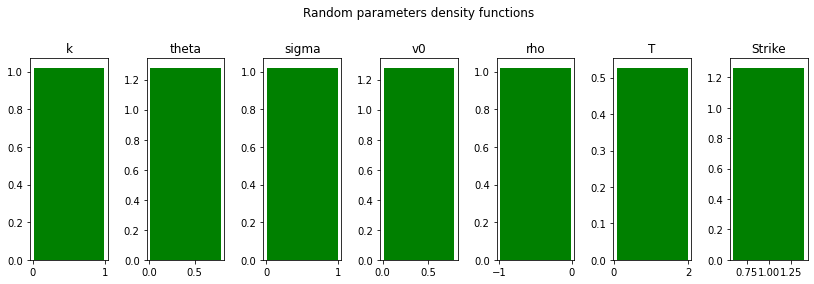

In [26]:
__tStart = time.perf_counter()
xDF = lhs_sampling(rand, NUM, bounds = bounds)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("LHS", __tEnd - __tStart) )

# Let's check the distribution of the parameters we have generated
histo_params( xDF, title = "Random parameters density functions")

**Generate random DB**

In [27]:
# Generate training/test set
__tStart = time.perf_counter()
df =  parms_gen( lhs = xDF, Xc=XC, strikes = strikes)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd - __tStart) )

100%|██████████| 100000/100000 [08:46<00:00, 189.98it/s]

@ Seq. pricing                      : elapsed 526.3804 sec
@ Info                              : Violations Put=21, Call=0 DB=99979 out of 100000
@ GEN                               : elapsed 526.4129 sec


In [29]:
df.head(10)

,k,theta,sigma,v0,rho,T,Strike,Price
0,0.579205,0.137107,0.809123,0.325332,-0.160029,1.490751,1.303812,0.431858
1,0.546654,0.600869,0.359396,0.055816,-0.757414,1.078189,0.607108,0.029463
2,0.442615,0.111116,0.388304,0.432567,-0.306024,0.545087,1.280964,0.372959
3,0.466167,0.055421,0.980264,0.666383,-0.061949,0.832530,0.996564,0.250543
4,0.333042,0.392680,0.092482,0.708127,-0.406727,0.847077,1.217092,0.441917
5,0.380423,0.754295,0.612885,0.608595,-0.726952,1.430491,0.921916,0.291633
6,0.165653,0.133465,0.387274,0.792238,-0.830328,1.016031,0.890468,0.255119
7,0.935586,0.782624,0.547595,0.556194,-0.873066,1.586565,1.074236,0.416522
8,0.222370,0.047442,0.452763,0.463867,-0.033873,1.249711,0.654660,0.093207
9,0.405262,0.554962,0.847436,0.655837,-0.764433,0.702656,1.298900,0.436044


Select a random subset as a challenge set

In [30]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

Add some noise to the training set

In [31]:
# Add some noise to the training set
if EPS > 0.0:
    X_train_n = X_train.copy()
    xl = np.min(X_train["Price"])
    xh = np.max(X_train["Price"])

    xi = rand.normal( loc = 0.0, scale = EPS*(xh-xl), size=X_train.shape[0])
    X_train_n["Price"] += xi
else: X_train_n = X_train

Display the amount of noise

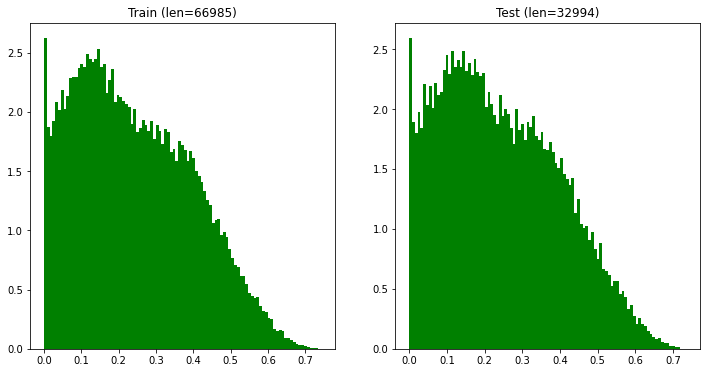

In [32]:
import warnings
warnings.simplefilter('ignore')
# Check the dispersion
if EPS > 0.0:
    xMin = 0.0
    xMax = max(X_train["Price"])
    v = np.arange(xMin, xMax, (xMax - xMin)/100.)

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    ax.plot( X_train["Price"], X_train_n["Price"], ".", markersize=1)
    ax.plot( v, v, color="red")
    ax.set_title("Perturbed")
    ax.set_xlabel("X train")
    ax.set_ylabel("X train with noise")

    #figName = "scatter_%s.png" %(TAG)
    figName = "scatter_noise.png" 
    plt.savefig(figName, format="png")
    plt.show()
    histo_dict( {"Train"    : np.array(X_train["Price"]), 
                 "Test"     : np.array(X_test["Price"]), 
                 "Perturbed": np.array(X_train_n["Price"]) }, TAG=TAG)
else:
    histo_dict( {"Train": np.array(X_train["Price"]), "Test": np.array(X_test["Price"]) }, TAG=TAG )

remove the target from the test set

In [33]:
Y = pd.DataFrame({"Price": X_test["Price"]})
X_test = X_test.drop(columns="Price")

### Saving dataset to disk

write training set to disk

In [41]:
outputFile = "%s_%s.csv" %(outputPrfx, TAG)
X_train_n.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: training data frame written to '%s'" %("Info", outputFile))
if verbose: print(outputFile); print(X)

@ Info                              : training data frame written to 'full_100000_MCA.csv'


In [42]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(outputFile)    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

write challenge set to disk

In [43]:
challengeFile = "%s_%s.csv" %(testPrfx, TAG)
X_test.to_csv(challengeFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: challenge data frame written to '%s'" %("Info", challengeFile))
if verbose: print(challengeFile); print(X_train)

@ Info                              : challenge data frame written to 'test_100000_MCA.csv'


In [44]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(challengeFile)    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

write target to disk

In [45]:
    targetFile = "%s_%s.csv" %(targetPrfx, TAG)
    Y.to_csv(targetFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: target data frame written to '%s'" %("Info", targetFile))
    if verbose: print(targetFile); print(Y)

@ Info                              : target data frame written to 'trgt_100000_MCA.csv'


In [46]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(targetFile)    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>